In [1]:
import sys
sys.path.append('../')

import Omega as o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tqdm.auto import tqdm
from warnings import filterwarnings

o.mpl_cast('white')
filterwarnings('ignore')

In [2]:
class Metrics:

    def __init__(self, returns_dict):
        self.returns_dict = returns_dict
        self.metrics_df = pd.DataFrame(columns=['Cumulative Return', 'Annual Return', 'Annual Volatility', 'Sharpe Ratio', 'Max Drawdown'])

    def calculate(self):
        for strategy, returns in self.returns_dict.items():
            returns = returns.squeeze()
            cumulative_return = self._cumulative_return(returns)
            annual_return = self._annual_return(returns)
            annual_volatility = self._annual_volatility(returns)
            sharpe_ratio = self._sharpe_ratio(returns)
            max_drawdown = self._max_drawdown(returns)
            self.metrics_df.loc[strategy] = [cumulative_return, annual_return, annual_volatility, sharpe_ratio, max_drawdown]
        return self.metrics_df

    @staticmethod
    def _cumulative_return(returns):
        return ((1 + returns).cumprod() - 1)[-1]

    @staticmethod
    def _annual_return(returns):
        return returns.mean() * 252

    @staticmethod
    def _annual_volatility(returns):
        return returns.std() * np.sqrt(252)

    @staticmethod
    def _sharpe_ratio(returns, risk_free_rate=0.02):
        excess_returns = returns - risk_free_rate / 252
        return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

    @staticmethod
    def _max_drawdown(returns):
        cum_returns = (1 + returns).cumprod()
        rolling_max = cum_returns.cummax()
        drawdown = (cum_returns - rolling_max) / rolling_max
        return drawdown.min()

In [3]:
class PCAModel:

    def __init__(self, stock_returns, lookback=60, num_components=1):
        self.stock_returns = stock_returns.copy()
        self.lookback = lookback
        self.num_components = num_components
        self.eigenportfolio_returns = pd.DataFrame(index=self.stock_returns.index)

        for i in range(1, self.num_components + 1):
            self.eigenportfolio_returns[f'EP{i}'] = np.nan

    def fit(self, display=True):
        pca = PCA(n_components=self.num_components)

        if display:
            desc = 'Calculating Eigenportfolio Returns'
            dates = tqdm(self.eigenportfolio_returns.index[self.lookback - 1:], desc=desc, position=0, leave=True)
        else:
            dates = self.eigenportfolio_returns.index[self.lookback - 1:]
            
        for date in dates:
            past_stock_returns = self.stock_returns.loc[:date][-self.lookback:]
            standardized_past_stock_returns = (past_stock_returns - past_stock_returns.mean() / past_stock_returns.std())
            pca.fit(standardized_past_stock_returns)

            for i in range(self.num_components):
                weights = pca.components_[i] / past_stock_returns.std()
                weights /= abs(weights).sum()
                self.eigenportfolio_returns.loc[date][f'EP{i+1}'] = (weights * past_stock_returns.iloc[-1]).sum()

        self.eigenportfolio_returns = self.eigenportfolio_returns[self.lookback - 1:]
        self.stock_returns = self.stock_returns[self.lookback - 1:]

In [4]:
class OUModel:

    def __init__(self, returns, stocks, etfs, lookback=60):
        self.returns = returns
        self.lookback = lookback
        self.stocks = stocks
        self.etfs = etfs
        self.T = (self.lookback / 2) / 252
        self._init_betas_and_s_scores()

    def fit(self, display=True):
        if display:
            dates = tqdm(self.returns.index[self.lookback - 1:], desc='1. Modelling OU', position=0, leave=True)
        else:
            dates = self.returns.index[self.lookback - 1:]

        for date in dates:
            past_returns = self.returns.loc[:date][-self.lookback:]
            past_returns = (past_returns - past_returns.mean()) / past_returns.std()
            OU_params = self._init_OU_params()
            for stock in past_returns.drop(columns=self.etfs):
                X = past_returns[self.etfs].values
                y = past_returns[stock].values
                REG_1 = LinearRegression().fit(X, y)
                self.betas.loc[date, stock] = REG_1.coef_
                residual_returns = y - REG_1.predict(X)
                cumulative_residual_returns = residual_returns.cumsum()
                X = cumulative_residual_returns[:-1].reshape(-1, 1)
                y = cumulative_residual_returns[1:]
                REG_2 = LinearRegression().fit(X, y)
                a = REG_2.intercept_
                b = REG_2.coef_
                zeta = y - REG_2.predict(X)
                kappa = -np.log(b) * 252
                sigma_eq = np.sqrt(np.var(zeta) / (1 - b**2))
                if kappa > (1 / self.T):
                    OU_params.loc[stock] = [x.item() for x in [a, b, np.var(zeta), kappa, sigma_eq]]
            OU_params = OU_params.dropna(axis=0)
            OU_params['m'] = (OU_params['a'] / (1 - OU_params['b'])) - (OU_params['a'].mean() / (1 - OU_params['b'].mean()))
            try:
                self.s_scores.loc[date] = -OU_params['m'] / OU_params['sigma_eq']
                self.s_scores.sort_index(inplace=True)
                self.betas.sort_index(inplace=True)
            except ZeroDivisionError:
                continue

    def _init_betas_and_s_scores(self):
        self.s_scores = pd.DataFrame(index=self.returns.drop(columns=self.etfs).index[self.lookback:], columns=self.stocks)
        self.betas = pd.DataFrame(index=self.returns.drop(columns=self.etfs).index[self.lookback:], columns=self.stocks)
        
    def _init_OU_params(self):
        return pd.DataFrame(index=self.stocks, columns=['a', 'b', 'var_zeta', 'kappa', 'sigma_eq'])

In [5]:
class Positions:

    def __init__(self, s_scores, betas, stocks, etfs):
        self.s_scores = s_scores
        self.betas = betas
        self.stocks = stocks
        self.etfs = etfs
        self.signals = pd.DataFrame(index=self.s_scores.index, columns=self.stocks)
    
    def get(self, display=True):
        self._generate_signals(display=display)
        self._get_weights(display=display)

    def _get_weights(self, display=True):
        if display:
            desc = '3. Computing Positions'
            dates = tqdm(self.signals.index, desc=desc, position=0, leave=True)
        else:
            dates = self.signals.index

        for date in dates:
            tmp = self.signals.loc[date].copy()
            tmp[tmp > 0] /= sum(tmp > 0)
            tmp[tmp < 0] /= sum(tmp < 0)
            self.weights.loc[date] = tmp
        if len(self.etfs) == 1:
            self.weights[self.etfs[0]] = -np.stack((self.betas.iloc[1:,:] * self.weights).sum(axis=1).values)
        else:
            self.weights[self.etfs] = (-np.stack((self.betas.iloc[1:,:] * self.weights).sum(axis=1).values))
    
    def _generate_signals(self, display=True):
        if display:
            desc = '2. Generating Signals'
            stocks = tqdm(self.stocks, desc=desc)
        else:
            stocks = self.stocks
        for stock in stocks:
            positions = pd.DataFrame(index=self.s_scores.index, columns=[stock])
            position = 0
            for day in self.s_scores.index:
                score = self.s_scores.loc[day][stock]
                if score > 1.25:
                    positions.loc[day][stock] = -1
                    position = -1
                elif score < -1.25:
                    positions.loc[day][stock] = 1
                    position = 1
                elif score < 0.75 and position == -1: 
                    positions.loc[day][stock] = 0
                    position = 0
                elif score > -0.5 and position == 1:
                    positions.loc[day][stock] = 0
                    position = 0
                else:
                    positions.loc[day][stock] = position
            self.signals[stock] = positions
        self.signals = self.signals.shift()[1:]
        self.weights = pd.DataFrame(index=self.signals.index, columns=self.stocks)

In [6]:
class Arby:

    def __init__(self, returns, snp_tickers, etf_tickers, lookback=60, leverage=2, costs=0.0005):
        self.all_returns = returns
        self.snp_tickers = snp_tickers
        self.etf_tickers = etf_tickers
        self.lookback = lookback
        self.leverage = leverage
        self.costs = costs
    
    def fit(self, display=True):
        self._fit_OU(display=display)
        self._get_positions(display=display)
        self._get_returns()

    def _fit_OU(self, display=True):
        self._OUModel = OUModel(self.all_returns, self.snp_tickers, self.etf_tickers, self.lookback)
        self._OUModel.fit(display=display)
        self.s_scores, self.betas = self._OUModel.s_scores, self._OUModel.betas

    def _get_positions(self, display=True):
        self._Positions = Positions(self._OUModel.s_scores, self._OUModel.betas, self.snp_tickers, self.etf_tickers)
        self._Positions.get(display=display)
        self.weights = self._Positions.weights
        self.signals = self._Positions.signals
    
    def _get_returns(self):
        self.returns = (self.all_returns.reindex(self.weights.index) * self.weights).sum(axis=1) / (abs(self.weights).sum(axis=1) / self.leverage)
        self.transaction_costs = self.costs * self.leverage * abs(self.signals.diff()).sum(axis=1) / abs(self.signals).sum(axis=1)
        self.returns -= self.transaction_costs
        self.growth = pd.Series(np.nancumprod(self.returns + 1) - 1, index=self.returns.index)

In [7]:
def get_etf_data(tickers, start, end, reindexer):

    etf_growth, etf_returns = {}, {}
    
    prices = o.Ticker(tickers).get_prices(start, end)
    returns = prices.pct_change()[1:].reindex(reindexer.index)
    growth = ((1 + returns).cumprod() - 1).reindex(reindexer.index)

    for column in growth.columns.to_list():
        etf_growth[column] = growth[[column]]
        etf_returns[column] = returns[[column]]
        
    return etf_returns, etf_growth

In [8]:
def test_Arby_pca(stock_returns, stock_tickers, etf_tickers, start, end, num_components=15, lookback=60):
    for i in tqdm(range(num_components), desc='Backtesting'):
        pca_model = PCAModel(stock_returns, lookback=lookback, num_components=i+1)
        pca_model.fit(display=False)
        factor_data = pca_model.eigenportfolio_returns
        new_stock_returns = pca_model.stock_returns
        factor_symbols = factor_data.columns.to_list()
        all_returns = pd.concat([new_stock_returns, factor_data], axis=1)
        arby = Arby(all_returns, stock_tickers, factor_symbols, lookback=lookback)
        arby.fit(display=False)
        etf_returns, etf_growth = get_etf_data(etf_tickers, start, end, arby.growth)
        ax = arby.growth.plot(label='Arby with PCA (Cost-Accounted), n = {}'.format(i+1), figsize=(15,4))
        for etf in etf_growth.values():
            etf.plot(ax=ax, label=etf)
        etf_returns['Arby'] = arby.returns
        metrics = Metrics(etf_returns)
        plt.legend(bbox_to_anchor=(1,1))
        plt.tight_layout()
        plt.show()
        display(metrics.calculate())
        print('-'*180)

---

In [9]:
start = '2020-01-01'
end = '2023-07-28'

stock_tickers = [ticker.replace('.', '-') for ticker in o.get_snp()]
etf_tickers = ['SPY', 'BBH', 'QQQ']

stock_prices = o.Ticker(stock_tickers).bulk_prices(start, end)
stock_returns_ = stock_prices.pct_change()[1:]

[*********************100%***********************]  503 of 503 completed


Backtesting:   0%|          | 0/15 [00:00<?, ?it/s]

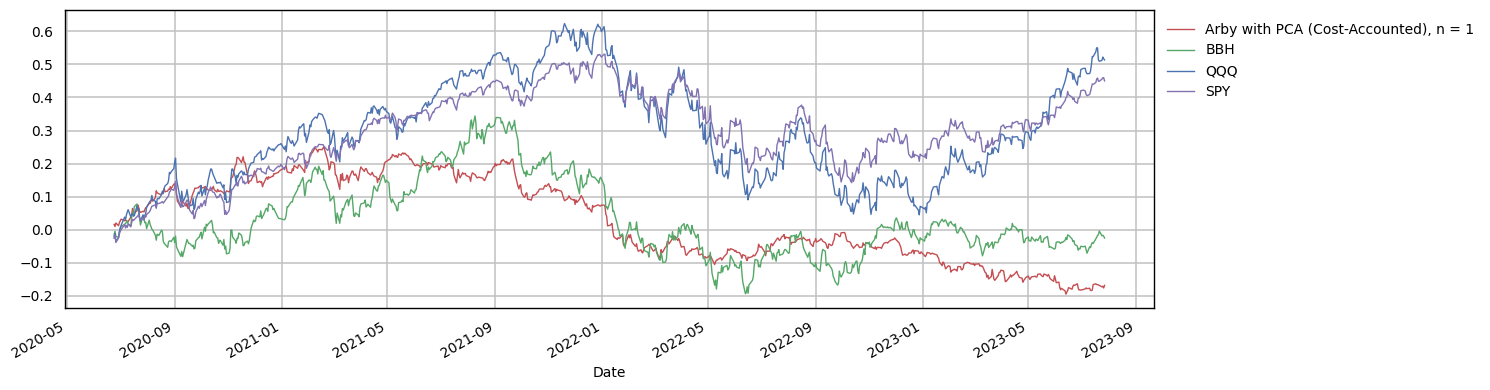

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.167972,-0.049754,0.140065,-0.498010,-0.356065


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


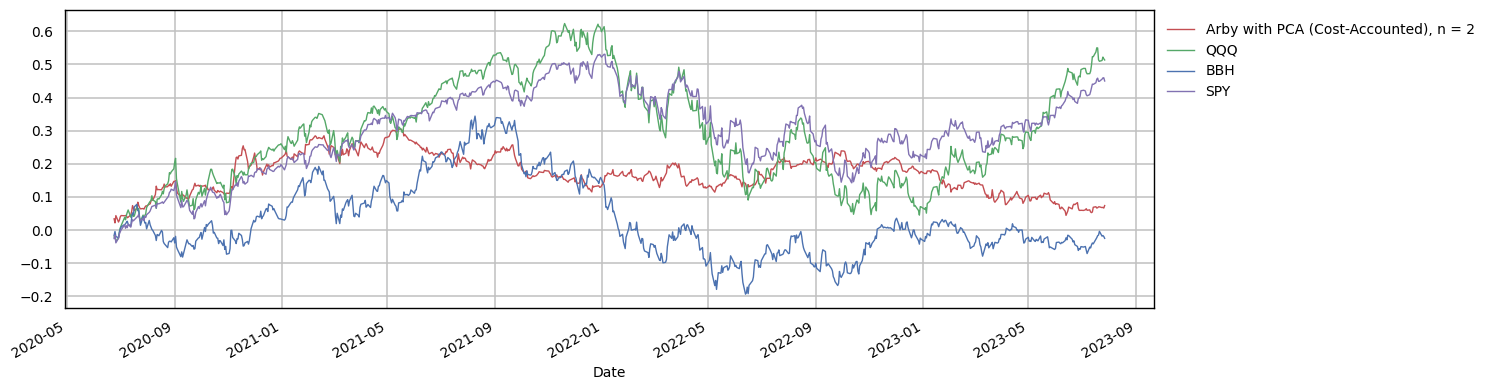

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,0.074053,0.031177,0.127169,0.087889,-0.199474


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


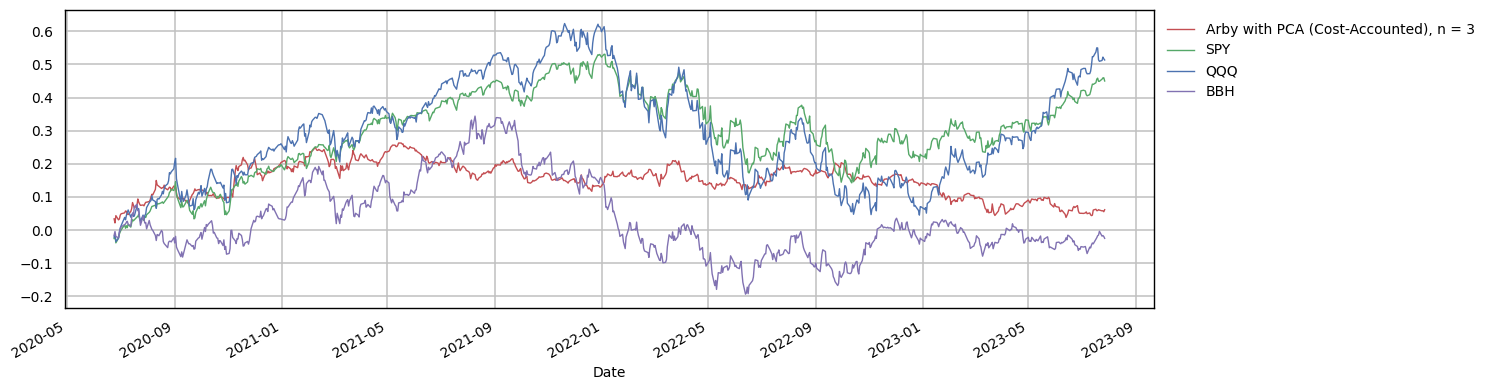

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
Arby,0.061584,0.026463,0.119677,0.054004,-0.177880


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


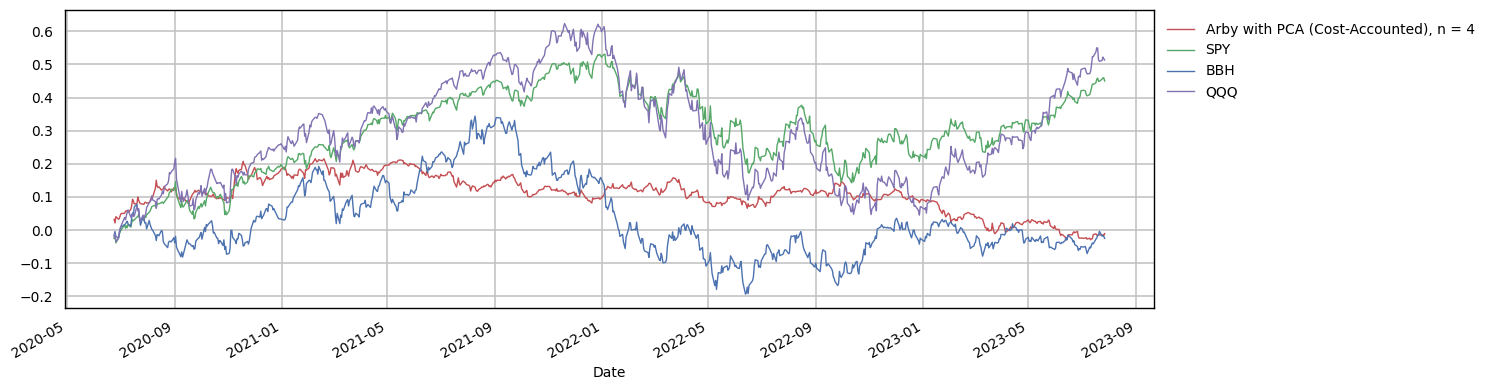

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.010398,0.003007,0.113493,-0.149724,-0.202067


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


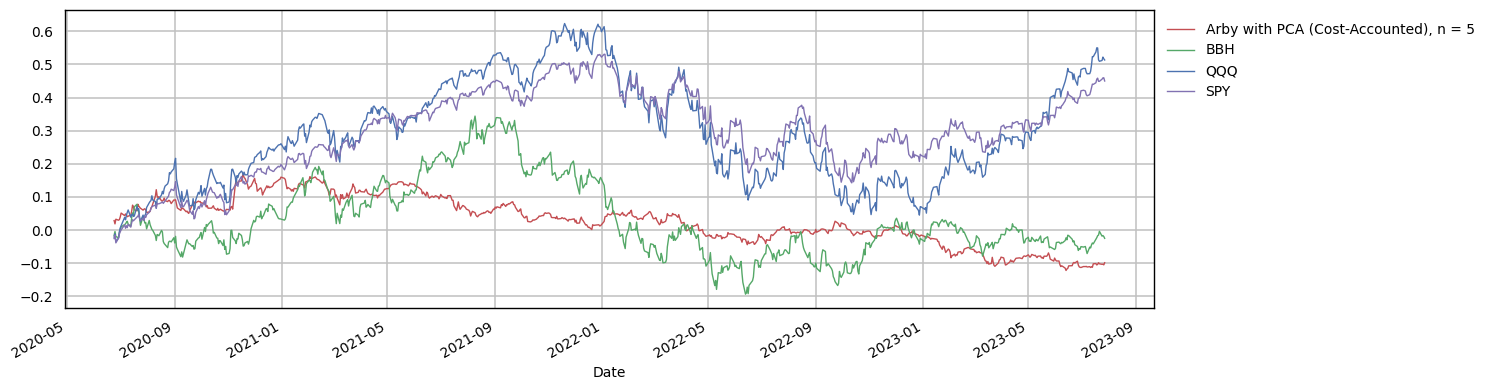

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.098463,-0.027500,0.110603,-0.429469,-0.249478


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


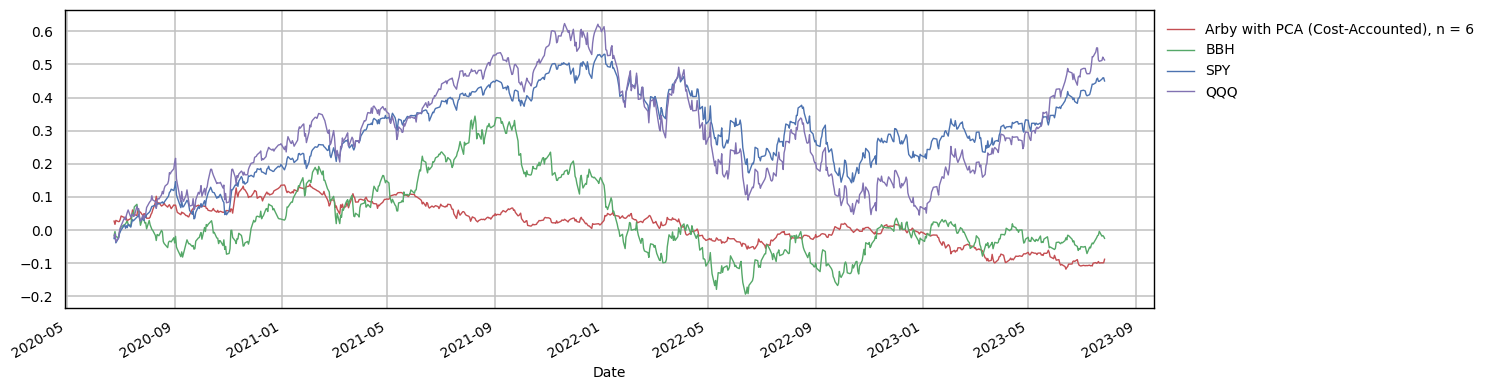

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.087945,-0.024440,0.103935,-0.427578,-0.225346


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


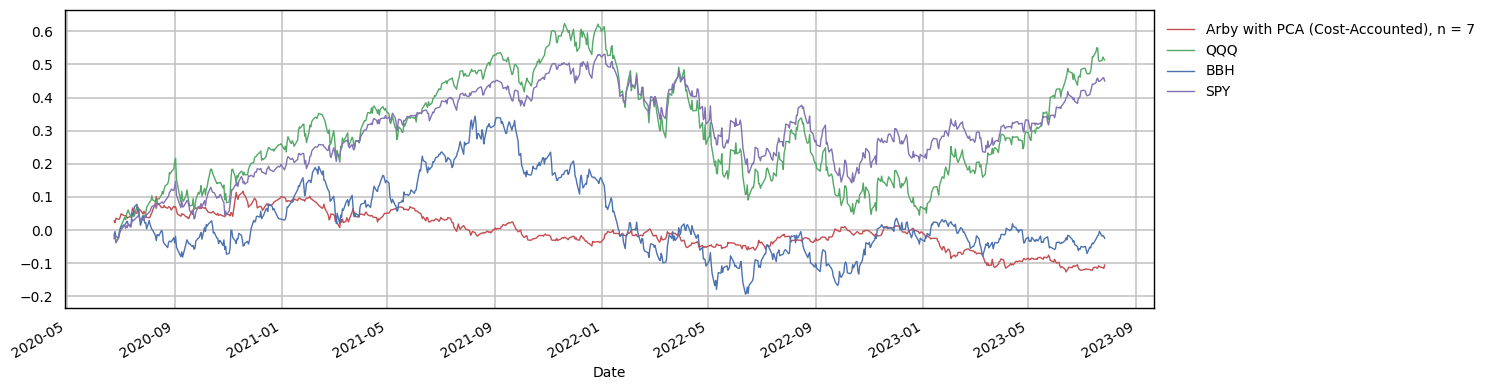

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.105551,-0.030900,0.102469,-0.496741,-0.217963


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


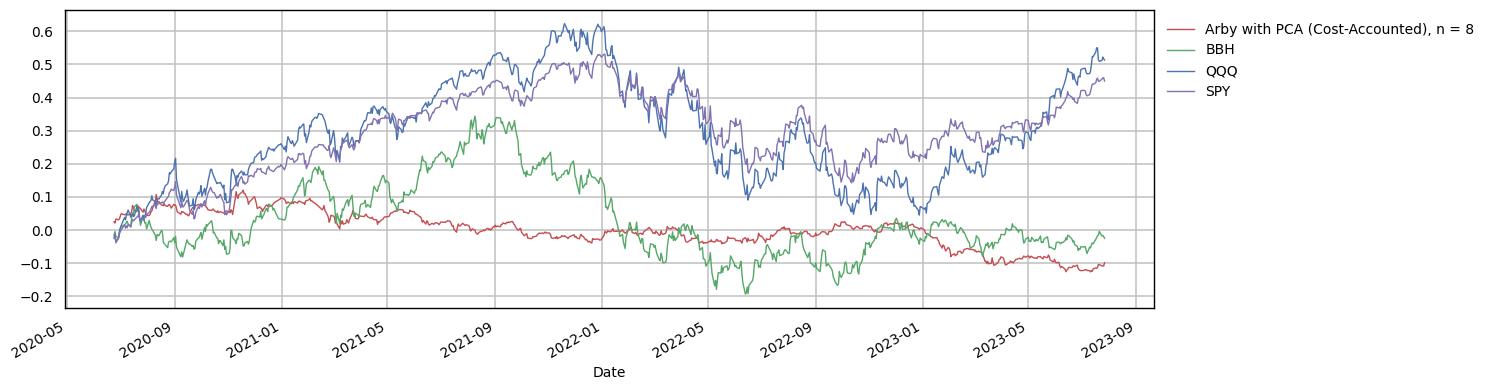

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.098184,-0.028535,0.099570,-0.487440,-0.219937


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


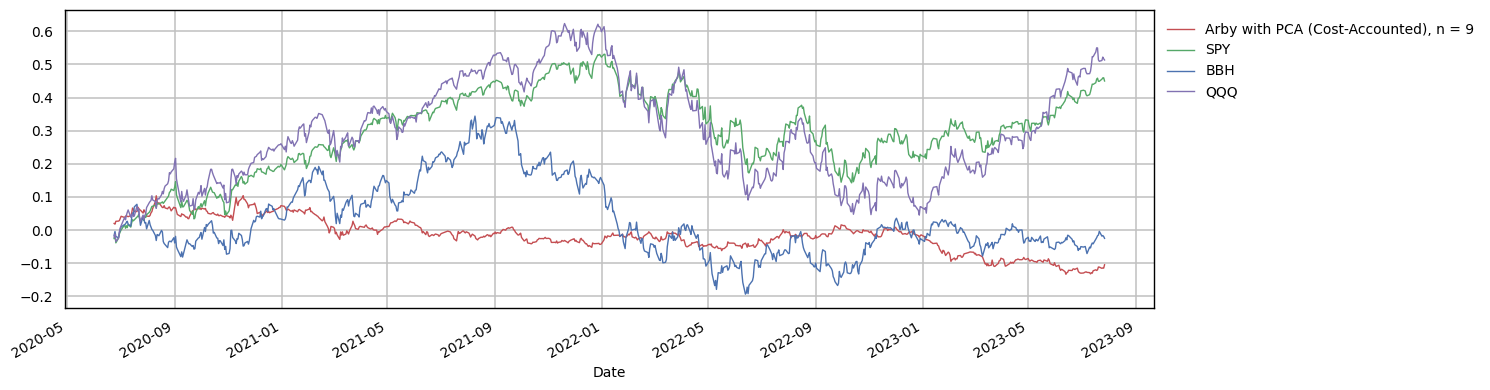

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.104600,-0.031038,0.097628,-0.522783,-0.214905


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


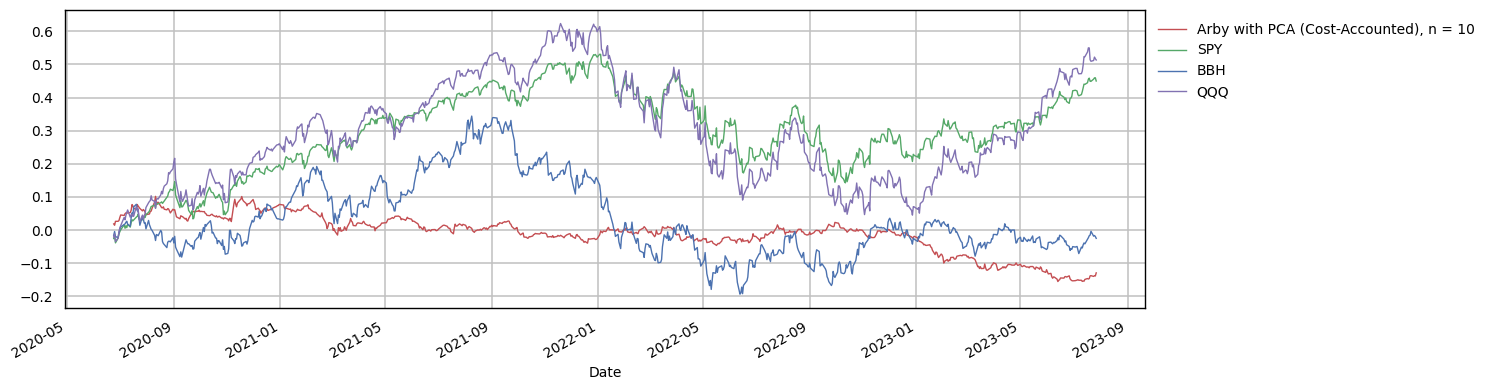

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.129058,-0.040283,0.094796,-0.635922,-0.233357


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


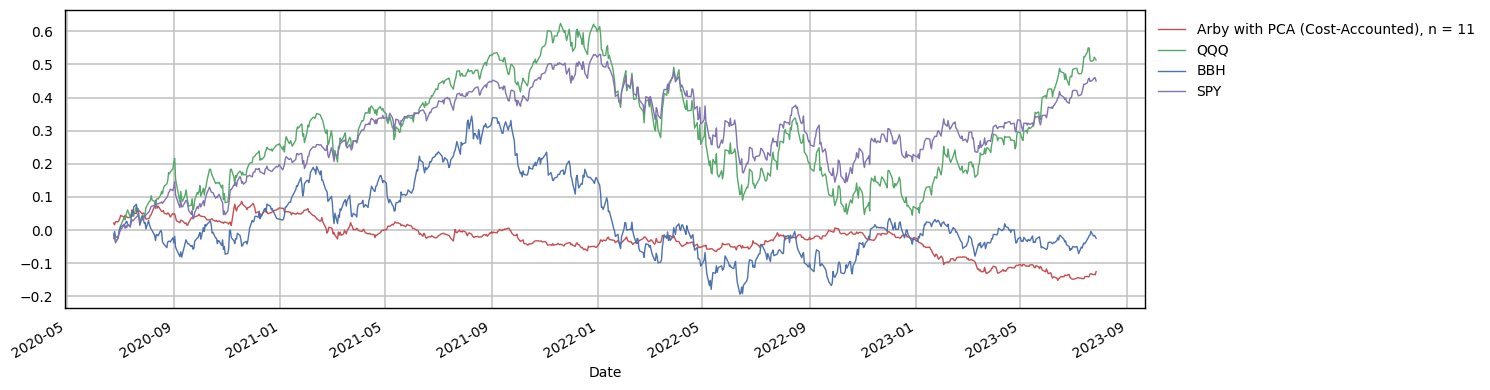

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.125324,-0.039120,0.092404,-0.639797,-0.221390


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


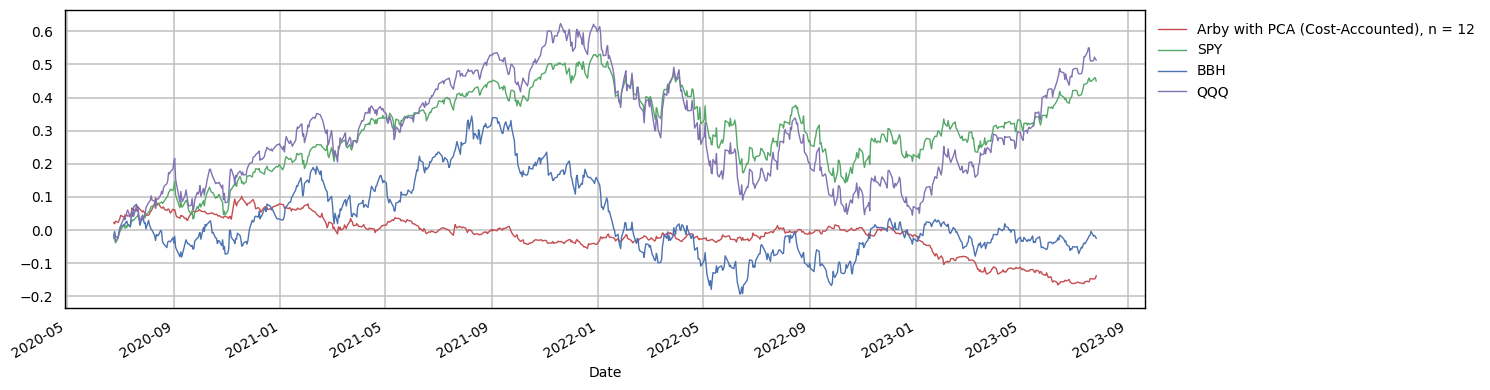

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.137776,-0.043946,0.090372,-0.707583,-0.242857


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


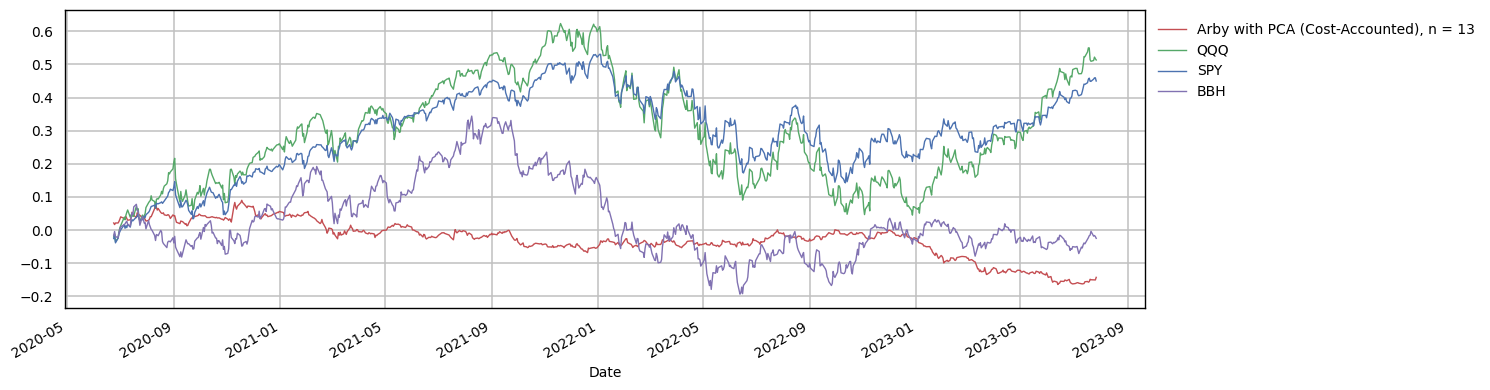

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
Arby,-0.142579,-0.046095,0.086516,-0.763959,-0.233208


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


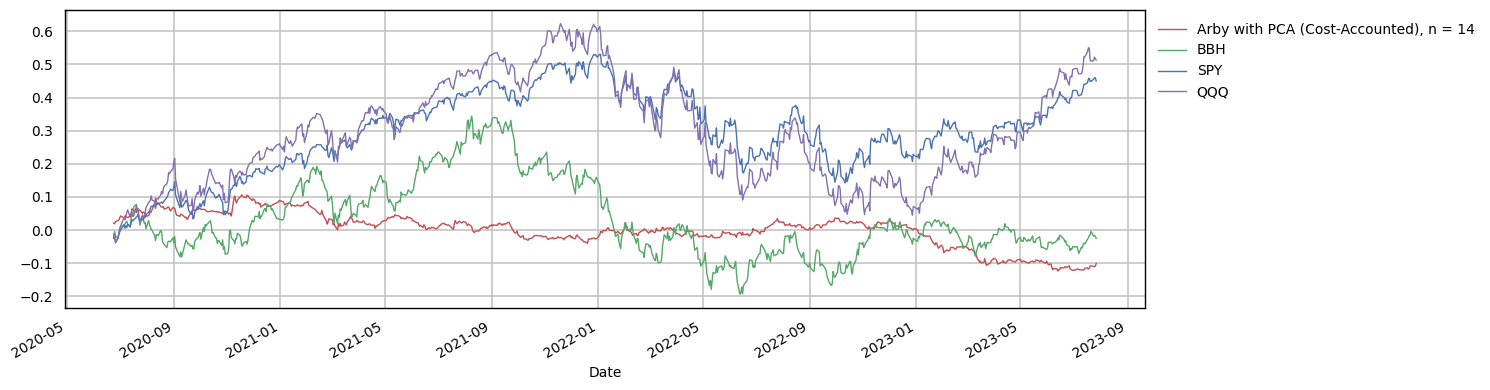

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
Arby,-0.100721,-0.030882,0.083913,-0.606368,-0.208050


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


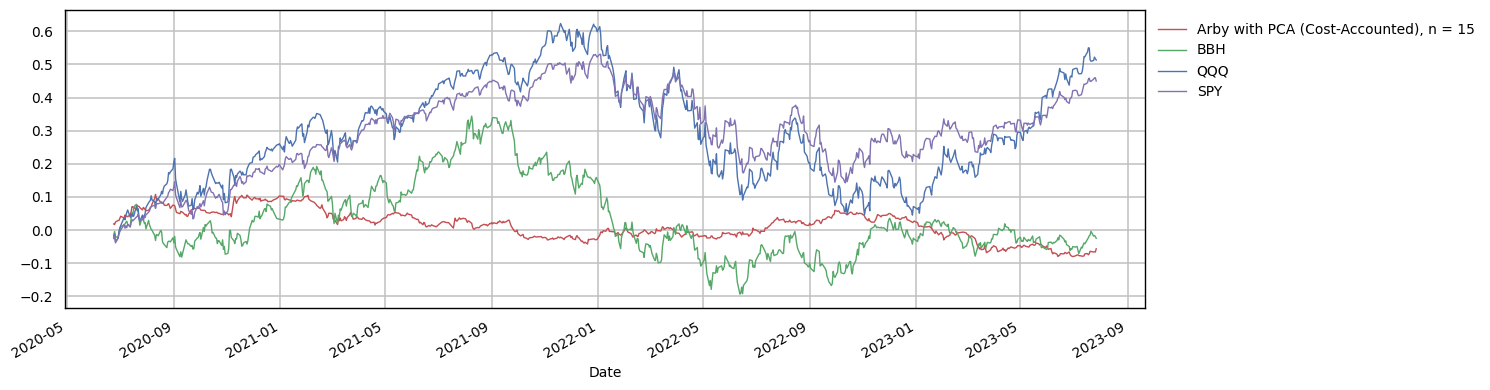

,Cumulative Return,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown
BBH,-0.024843,0.020841,0.240962,0.003491,-0.399864
QQQ,0.513503,0.164863,0.247315,0.585743,-0.356172
SPY,0.450056,0.137005,0.182251,0.642001,-0.253606
Arby,-0.056412,-0.015425,0.082461,-0.429598,-0.169206


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
test_Arby_pca(stock_returns_, stock_tickers, etf_tickers, start, end, num_components=15, lookback=60)